
## Imports

In [1]:
from io import open
import unicodedata
import string
import re
import random
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import operator

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

Loading data files
==================




In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-07-11 12:03:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.206.82, 99.84.206.72, 99.84.206.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.206.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2021-07-11 12:03:33 (70.9 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

# Glove Vectors

In [4]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [5]:
# !wget https://nlp.stanford.edu/data/glove.42B.300d.zip
# !unzip glove.42B.300d.zip
# !rm -rf glove.42B.300d.zip

In [6]:
# !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip glove.twitter.27B.zip
# !rm -rf glove.twitter.27B.zip

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
glove_path = f'/content/drive/MyDrive/glove'

In [9]:
# glove_words = []
# idx = 0
# glove_word2id = {}
# glove_vectors = []

# with open(f'{glove_path}/glove.6B.100d.txt', 'rb') as f:
#     for l in f:
#         line = l.decode().split()
#         word = line[0]
#         glove_words.append(word)
#         glove_word2id[word] = idx
#         idx += 1
#         word_vector = np.array(line[1:]).astype(np.float)
#         glove_vectors.append(word_vector)


In [10]:
# glove_words = []
# idx = 0
# glove_word2id = {}
# glove_vectors = []

# with open(f'{glove_path}/glove.42B.300d.txt', 'rb') as f:
#     for l in f:
#         line = l.decode().split()
#         word = line[0]
#         glove_words.append(word)
#         glove_word2id[word] = idx
#         idx += 1
#         word_vector = np.array(line[1:]).astype(np.float)
#         glove_vectors.append(word_vector)


In [11]:
glove_words = []
idx = 0
glove_word2id = {}
glove_vectors = []

with open(f'{glove_path}/glove.twitter.27B.200d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        glove_words.append(word)
        glove_word2id[word] = idx
        idx += 1
        word_vector = np.array(line[1:]).astype(np.float)
        glove_vectors.append(word_vector)


In [12]:
glove_word2vec = {word: glove_vectors[glove_word2id[word]] for word in glove_words}

In [13]:
# n_glove_vectors = len(glove_words)
# dim_glove_vectors = 100

In [ ]:
# class InputLang:
#     def __init__(self, name):
#         self.name = name
#         self.word2index = { k : v for k , v in sorted(glove_word2id.items(), key=operator.itemgetter(1))}
#         self.word2count = { word : 1 for word in glove_words }
#         self.index2word = { i : word for word, i in glove_word2id.items() }
#         self.n_words = len(glove_words)
#     def addSentence(self, sentence):
#         for word in sentence.split(' '):
#             self.addWord(word)
#     def addWord(self, word):
#         if word not in self.word2index:
#             print(word)
#             self.word2index[word] = self.n_words
#             self.word2count[word] = 1
#             self.index2word[self.n_words] = word
#             self.n_words += 1
#         else:
#             self.word2count[word] += 1

In [14]:
SOS_token = 0
EOS_token = 1

class InputLang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Count SOS and EOS
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [15]:
SOS_token = 0
EOS_token = 1

class OutputLang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Count SOS and EOS
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [16]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [17]:
def readLangs():
    print("Reading lines...")
    # Read the file and split into lines
    lines = open('data/eng-fra.txt', encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    pairs = [list((p)) for p in pairs]
    input_lang = InputLang('eng')
    output_lang = OutputLang('fra')
     
    return input_lang, output_lang, pairs

In [18]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [19]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs
input_lang, output_lang, pairs = prepareData()
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 4345
['they re almost here .', 'elles en sont presque la .']


In [20]:
input_vocab_size = input_lang.n_words
weights_matrix = np.zeros((input_vocab_size, 200))
words_found = 0
for i, word in enumerate(input_lang.word2index):
    try: 
        weights_matrix[i] = glove_word2vec[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(200, ))


The Seq2Seq Model
=================



The Encoder
-----------



In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        # Make this vector non-trainable
        for param in self.embedding.parameters():
            param.requires_grad = False
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Attention Decoder







In [22]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Training
========

Preparing Training Data
-----------------------



In [23]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------




In [24]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [25]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [27]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========





In [28]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [29]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================






In [30]:
hidden_size = 200
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 8s (- 16m 2s) (5000 6%) 3.6515
2m 15s (- 14m 37s) (10000 13%) 3.0883
3m 21s (- 13m 24s) (15000 20%) 2.8689
4m 27s (- 12m 16s) (20000 26%) 2.7000
5m 33s (- 11m 6s) (25000 33%) 2.5219
6m 38s (- 9m 58s) (30000 40%) 2.4022
7m 44s (- 8m 50s) (35000 46%) 2.2888
8m 49s (- 7m 43s) (40000 53%) 2.1757
9m 55s (- 6m 36s) (45000 60%) 2.0288
11m 1s (- 5m 30s) (50000 66%) 1.9426
12m 6s (- 4m 24s) (55000 73%) 1.8544
13m 11s (- 3m 17s) (60000 80%) 1.7584
14m 19s (- 2m 12s) (65000 86%) 1.6687
15m 25s (- 1m 6s) (70000 93%) 1.6282
16m 32s (- 0m 0s) (75000 100%) 1.5306


In [31]:
evaluateRandomly(encoder1, attn_decoder1)

> he s leaning on a cane .
= il s appuie sur une canne .
< il est tout un un un . <EOS>

> he is unable to buy a car .
= il est incapable d acheter une voiture .
< il est probable qu un un gentleman . <EOS>

> i m glad you came over .
= je me rejouis que vous soyez venus .
< je me rejouis que vous soyez . . <EOS>

> i m going crazy .
= je deviens fou .
< je vais a . <EOS>

> i am from brazil .
= je viens du bresil .
< je suis du bresil . <EOS>

> i m being paid to do this .
= on me paie pour faire ca .
< je suis impatiente de de faire ca . <EOS>

> i m glad that tom is here .
= je suis content que tom soit la .
< je suis que que tom est ici . <EOS>

> we re finished .
= nous avons fini .
< nous en avons termine . <EOS>

> i m not signing anything .
= je ne signe rien du tout .
< je n suis rien . <EOS>

> you re very forward .
= tu es fort effronte .
< vous etes tres effrontee . <EOS>



Visualizing Attention
---------------------




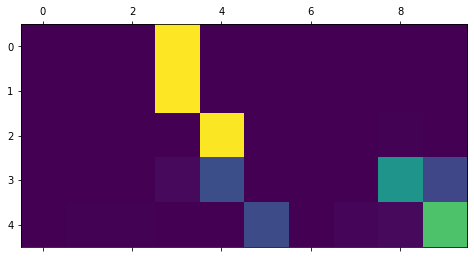

In [32]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "i am sorry .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:

input = i am not ok .
output = je ne suis pas pas . <EOS>


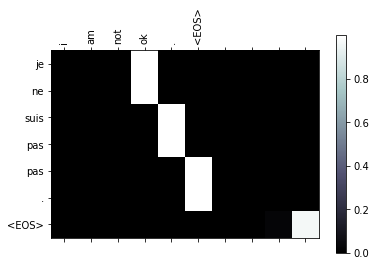

input = he is a bad person .
output = c est un personne de . <EOS>


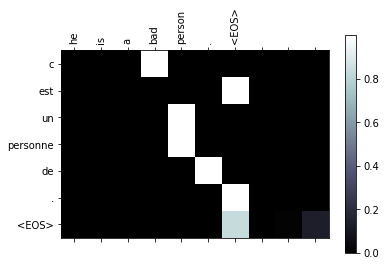

input = she is fast .
output = elle est en . <EOS>


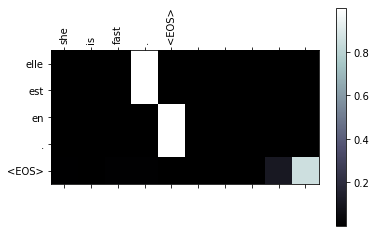

input = we are going tomorrow .
output = nous nous dirigeons . <EOS>


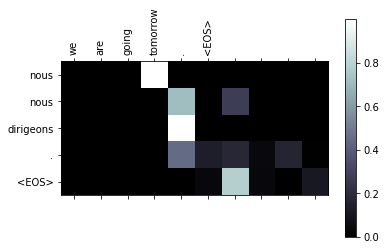

In [33]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("i am not ok .")

evaluateAndShowAttention("he is a bad person .")

evaluateAndShowAttention("she is fast .")

evaluateAndShowAttention("we are going tomorrow .")